In [1]:
import os
import pathlib
import time

import config
os.chdir(config.PROJECT_ROOT_PATH)

import fitz
import json


from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from pylab import rcParams
rcParams['figure.figsize'] = 8,8

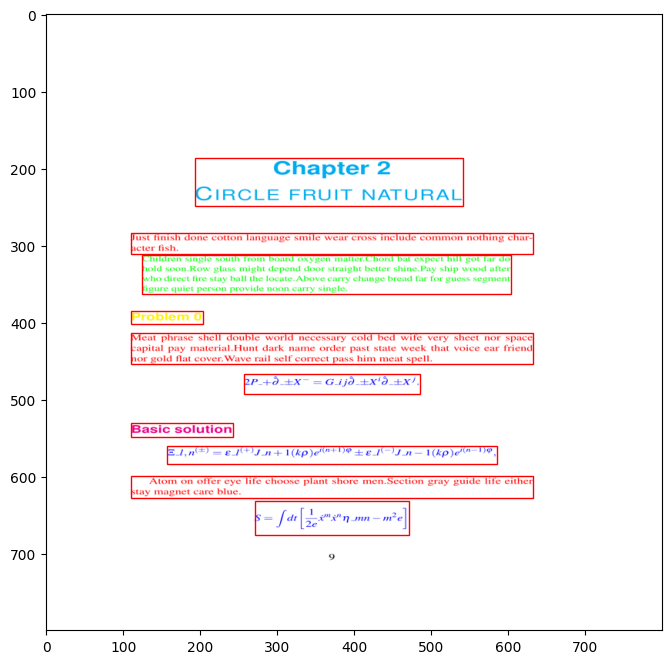

In [8]:
def plot_many(arrays):
    if not isinstance(arrays, list):
        arrays = [arrays]

    f = plt.figure()
    for i, x in enumerate(arrays):
        f.add_subplot(1,len(arrays),i+1)
        plt.imshow(x, cmap='gray')


class PageMarkupper:
    def __init__(self, documetnpath, colormapping, datapath, colors, classes_list, classes_nums, orig_class_name):
        self.doc = fitz.open(documetnpath)

        self.datapath = pathlib.Path(datapath)
        self.colormapping = colormapping
        self.colors = colors
        self.classes_list = classes_list
        self.classes_nums = classes_nums
        self.orig_class_name = orig_class_name

        self.dpi = 250

        pixmap = self.doc[0].get_pixmap(dpi=self.dpi)
        self.imgshape = pixmap.height, pixmap.width
        self.imgheight, self.imgwidth = self.imgshape

        pixmap = self.doc[0].get_pixmap()
        self.orig_imgshape = pixmap.height, pixmap.width
        self.orig_imgheight, self.orig_imgwidth = self.imgshape

        self.scale = self.imgheight / self.doc[0].get_pixmap().height

    def define_color(self, abc):
        distances = dict(map(
            lambda x: (x[0], np.sqrt(
                (x[1][0]-abc[0])**2 + (x[1][1]-abc[1])**2 + (x[1][2]-abc[2])**2
            )),
            self.colors.items()
        ))
        m = min(distances.values())
        color = [key for key, val in distances.items() if val == m][0]
        return color

    def define_line_color(self, x):
        colors = set(map(self.define_color, map(tuple, np.unique(x, axis=0))))
        for col in ['black', 'red', 'blue', 'green', 'yellow', 'cyan', 'brown', 'magenta']:
            if col in colors:
                return col
        return 'white'

    def slice_page_into_class_tapes(self, img):
        colors_lines = []
        tapes = {}
        c1 = None
        c2 = None
        for i, x in enumerate(img):
            color = self.define_line_color(x)
            tapes[color] = set()
            if color == 'white':
                continue
            if color == c1 and color == c2:
                colors_lines[-1] = (i, color)
            elif color == c1 and color != c2:
                colors_lines.append((i, color))
                c2 = color
            elif color != c1:
                colors_lines.append((i, color))
                c2 = c1
                c1 = color

        for i in range(0, len(colors_lines), 2):
            color = colors_lines[i][1]
            y1 = colors_lines[i][0]
            y2 = colors_lines[i+1][0]
            tapes[color].add((y1,y2))

        return tapes

    def create_class_mask_from_tapes(self, tapes, img):
        mask = np.zeros(self.imgshape, dtype='int8')
        for tape in tapes:
            y1, y2 = tape
            for i in range(y1,y2+1):
                row = img[i]
                nonwhite_indexes = np.where(row != 255)[0]
                if nonwhite_indexes.size == 0:
                    continue

                left_index, right_index = nonwhite_indexes[0], nonwhite_indexes[-1]
                mask[i, left_index:right_index] = 255

        return mask

    def yscale(self, y):
        return int(y*self.scale)

    def xscale(self, x):
        return int(x*self.scale)

    def get_images_binary_mask(self, page):
        mask = np.zeros(self.imgshape, dtype='uint8')
        bboxes = [page.get_image_bbox(name) for name in map(lambda x: x[-2], page.get_images())]
        for bbox in bboxes:
            x1, y1, x2, y2 = bbox
            mask[self.yscale(y1):self.yscale(y2), self.xscale(x1): self.xscale(x2)] = 255
        return mask

    def create_bg_mask(self, other_masks):
        mask = np.empty(self.imgshape, dtype='int8')
        mask.fill(255)
        for om in other_masks:
            mask -= om
        return mask

    def create_empty_mask(self):
        return np.zeros(self.imgshape, dtype='int8')

    def save_mask(self, img, pagenum, classname):
        path = self.datapath.joinpath(str(pagenum), classname+'.bmp')
        path.parent.mkdir(parents=True, exist_ok=True)
        img = Image.fromarray(img.astype('uint8'))
        img.save(path)

    def make_img_monocrome(self, img):
        img = np.mean(img, axis=2)
        border = 120
        img[img>=border] = 255
        img[img<border] = 0
        return img

    def markup_page_i(self, i, plot=False, method='bbox_only'):
        assert method in ['textbbox', 'tape', 'bbox_only']

        page = self.doc[i]
        pix = page.get_pixmap(dpi=self.dpi)
        img = np.frombuffer(buffer=pix.samples, dtype=np.uint8).reshape((pix.height, pix.width, 3))

        # PLOT
        if plot:
            plt.figure()
            # plt.imshow(img, cmap='gray')
            plt.imshow(self.make_img_monocrome(img), cmap='gray')


        if method == 'tape':
            masks = {}
            tapes = self.slice_page_into_class_tapes(img)
            for color, tapes_set in tapes.items():
                if color in ['white', 'black']:
                    continue
                class_name = config.CLASS_COLOR_MAPPING[color]
                mask = self.create_class_mask_from_tapes(tapes=tapes_set, img=img)
                masks[class_name] = mask
        elif method=='textbbox':
            masks = {}
            for classname in self.classes_list:
                masks[classname] = self.create_empty_mask()

            blocks = json.loads(page.get_textpage().extractJSON())['blocks']
            for block in blocks:
                for line in block['lines']:
                    for span in line['spans']:
                        color = self.define_color(fitz.sRGB_to_rgb(span['color']))
                        classname = self.colormapping[color]
                        if classname not in self.classes_list:
                            break
                        x1,y1,x2,y2 = span['bbox']
                        masks[classname][self.yscale(y1):self.yscale(y2), self.xscale(x1): self.xscale(x2)] = 255
                if classname == 'formula':
                    x1,y1,x2,y2 = block['bbox']
                    masks[classname][self.yscale(y1):self.yscale(y2), self.xscale(x1): self.xscale(x2)] = 255
        elif method=='bbox_only':
            bboxes = []
            lables = []

            # выцепляем блоки, сохраняем лейблы и ббоксы
            blocks = json.loads(page.get_textpage().extractJSON())['blocks']
            for block in blocks:
                classnames = set()
                for line in block['lines']:
                    for span in line['spans']:
                        color = self.define_color(fitz.sRGB_to_rgb(span['color']))
                        classname = self.colormapping[color]
                        classnames.add(classname)
                        if classname not in self.classes_list:
                            break
                        # x1,y1,x2,y2 = span['bbox']
                        # masks[classname][self.yscale(y1):self.yscale(y2), self.xscale(x1): self.xscale(x2)] = 255
                if classname not in self.classes_list:
                    continue
                x1,y1,x2,y2 = block['bbox']
                y1,y2,x1,x2 = self.yscale(y1),self.yscale(y2), self.xscale(x1), self.xscale(x2)

                if lables and lables[-1] == self.classes_nums[classname] == self.classes_nums['formula'] and y1 <= bboxes[-1][2]:
                    y1p, x1p, y2p, x2p = bboxes[-1]
                    bboxes[-1] = (
                        min(y1p, y1),
                        min(x1p, x1),
                        max(y2p, y2),
                        max(x2p, x2)
                    )
                else:
                    bboxes.append((y1, x1, y2, x2))
                    lables.append(self.classes_nums[classname])

            # отдельно выцепляем картинки
            img_bboxes = [page.get_image_bbox(name) for name in map(lambda x: x[-2], page.get_images())]
            for bbox in img_bboxes:
                x1, y1, x2, y2 = bbox
                y1,y2,x1,x2 = self.yscale(y1),self.yscale(y2), self.xscale(x1), self.xscale(x2)
                bboxes.append((y1, x1, y2, x2))
                lables.append(self.classes_nums['img'])

            # рескейлим ббоксы для 800*800
            x_scale = 800/self.imgwidth
            y_scale = 800/self.imgheight
            for j, (y1, x1, y2, x2) in enumerate(bboxes):
                bboxes[j] = (
                    y1*y_scale,
                    x1*x_scale,
                    y2*y_scale,
                    x2*x_scale,
                )

            if plot:
                plot_img = Image.fromarray(img).resize((800,800))
                plt.imshow(plot_img)
                for bbox in bboxes:
                    y1, x1, y2, x2 = bbox
                    xm = (x1+x2) / 2
                    ym = (y1+y2) / 2
                    h = (y2-y1)
                    w = (x2-x1)
                    plt.gca().add_patch(Rectangle((x1,y1),w,h,
                                                  edgecolor='red',
                                                  facecolor='none',
                                                  lw=1))

            if len(lables) == 0:
                print('SKIP blank page')
                return
            assert len(bboxes) == len(lables)

            path = pathlib.Path('/home/f/Programming/projects/scans_to_pdf_cg_cv/data2/').joinpath(str(i), 'description.json')
            path.parent.mkdir(parents=True, exist_ok=True)

            with open(path, 'w') as f:
                json.dump({
                    'bboxes': bboxes,
                    'lables': lables
                }, f, indent=2)

        if method == 'tape' or method=='textbox':
            images_mask = self.get_images_binary_mask(page)
            masks['img'] = images_mask

            bg_mask = self.create_bg_mask(masks.values())
            masks['bg'] = bg_mask

            for class_name in self.classes_list:
                if class_name not in masks.keys():
                    masks[class_name] = self.create_empty_mask()

            # PLOT
            if plot:
                plot_many(list(masks.values()))

                for classname, mask in masks.items():
                    self.save_mask(
                        pagenum=i,
                        classname=classname,
                        img=mask,
                    )

            self.save_mask(
                pagenum=i,
                classname=self.orig_class_name,
                img=self.make_img_monocrome(img)
            )
        elif method == 'bbox_only':
            path = pathlib.Path('/home/f/Programming/projects/scans_to_pdf_cg_cv/data2/').joinpath(str(i), 'img.png')
            path.parent.mkdir(parents=True, exist_ok=True)
            img = self.make_img_monocrome(img)
            img = Image.fromarray(img.astype('uint8')).resize((800, 800))
            img.save(path)

    def markup_doc(self, method='bbox_only'):
        for i in range(len(self.doc)):
        # for i in range(30):
            if i == 0:
                start_time = time.time()
                self.markup_page_i(i, method=method)
                time_per_page = time.time() - start_time
            else:
                remain = int(time_per_page*(len(self.doc) - i))
                print(f'markedup {i}/{len(self.doc)-1}, remaining time is {remain} seconds,', 'time to put the kettle on' if remain > 60 else 'almost ready')
                self.markup_page_i(i, method=method)

pm = PageMarkupper(
    documetnpath=pathlib.Path(config.LATEX_PLAYGROUND_PATH).joinpath('main.pdf'),
    colormapping=config.CLASS_COLOR_MAPPING,
    datapath=config.DATA_PATH,
    colors=config.COLORS,
    classes_list=config.CLASSES_LIST,
    classes_nums=config.CLASSES_NUMS,
    orig_class_name=config.ORIG_CLASS_NAME
)

pm.markup_page_i(8, plot=True)


In [3]:
! rm -r data2/*

In [4]:
pm.markup_doc()

markedup 1/180, remaining time is 41 seconds, almost ready
markedup 2/180, remaining time is 41 seconds, almost ready
markedup 3/180, remaining time is 41 seconds, almost ready
markedup 4/180, remaining time is 41 seconds, almost ready
markedup 5/180, remaining time is 40 seconds, almost ready
markedup 6/180, remaining time is 40 seconds, almost ready
markedup 7/180, remaining time is 40 seconds, almost ready
SKIP blank page
markedup 8/180, remaining time is 40 seconds, almost ready
markedup 9/180, remaining time is 39 seconds, almost ready
markedup 10/180, remaining time is 39 seconds, almost ready
markedup 11/180, remaining time is 39 seconds, almost ready
markedup 12/180, remaining time is 39 seconds, almost ready
markedup 13/180, remaining time is 39 seconds, almost ready
markedup 14/180, remaining time is 38 seconds, almost ready
markedup 15/180, remaining time is 38 seconds, almost ready
SKIP blank page
markedup 16/180, remaining time is 38 seconds, almost ready
markedup 17/180, 

In [5]:
!ls /home/f/Programming/projects/scans_to_pdf_cg_cv/data2

0/    11/   121/  134/  146/  159/  170/  2/   32/  44/  57/  70/  82/  95/
1/    110/  122/  135/  147/  16/   171/  20/  33/  45/  58/  71/  84/  98/
10/   111/  123/  136/  148/  160/  172/  21/  34/  46/  59/  72/  85/  99/
100/  112/  124/  137/  149/  161/  173/  22/  35/  47/  6/   73/  86/
101/  113/  125/  138/  150/  162/  174/  24/  36/  48/  60/  74/  87/
102/  114/  126/  139/  151/  163/  175/  25/  37/  49/  61/  75/  88/
103/  115/  128/  14/   152/  164/  176/  26/  38/  5/   62/  76/  89/
104/  116/  129/  140/  153/  165/  177/  27/  39/  50/  63/  77/  9/
105/  117/  13/   141/  154/  166/  178/  28/  4/   51/  64/  78/  90/
106/  118/  130/  142/  155/  167/  179/  29/  40/  52/  65/  79/  91/
107/  119/  131/  143/  156/  168/  18/   3/   41/  53/  66/  8/   92/
108/  12/   132/  144/  157/  169/  180/  30/  42/  54/  68/  80/  93/
109/  120/  133/  145/  158/  17/   19/   31/  43/  56/  69/  81/  94/
